In [1]:
from kmod import gan_ume_opt as gt
%load_ext autoreload
%autoreload 2
%matplotlib inline
#%config InlineBackend.figure_format = 'svg'
#%config InlineBackend.figure_format = 'pdf'

import kmod
import kgof
import kgof.goftest as gof
# submodules
from kmod import data, density, kernel, util
from kmod import mctest as mct
import matplotlib
import matplotlib.pyplot as plt
import autograd.numpy as np
import scipy.stats as stats

import utils, torch, time, os, pickle
import numpy as np
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from PIL import Image

In [2]:
from kmod.torch_models import Generator as DCGAN

In [ ]:
torch.backends.cudnn.enabled = True

In [ ]:
data_dir = '../problems/celeba/img_align_celeba'
test_img_list = []
with open('../problems/celeba/test_list.txt') as f:
    for line in f:
        test_img_list.append(line.rstrip('\n'))

In [ ]:
def open_images(paths, size=64, resize=False):
    img_data = []
    for path in paths:
        im = Image.open(path)
        if resize:
            im = im.resize((size, size))
        im = np.array(im)
        img_data.append(im)
    return np.array(img_data)

def normalize(images, mean, std):
    """normalize ndarray images of shape N x H x W x C"""
    return (images - mean) / std

## Experiments on noise space optimization (under construction)

In [3]:
batch_size = 1000 #number of images we want to generate
z_dim = 100 #dimention of noise, this is fixed to 100 so don't change
model_dir = '../problems/celeba/models/'
gpu_id = 2
gpu_mode = True
gt.set_gpu_mode(gpu_mode)
gt.set_gpu_id(gpu_id)
gp = DCGAN().cuda(gpu_id)
gp.eval()
gq = DCGAN().cuda(gpu_id)
gq.eval()
gp.load('{}/GAN_G_smile_unif.pkl'.format(model_dir))
gq.load('{}/GAN_G_nosmile_unif.pkl'.format(model_dir))

In [12]:
J = 5

from kmod.ex import celeba as clba 
gen_data_smile = clba.load_feature_array('gen_smile')
gen_data_nonsmile = clba.load_feature_array('gen_nonsmile')
ref = clba.load_feature_array('ref_smile')
datap = data.Data(gen_data_smile[:batch_size])
dataq = data.Data(gen_data_nonsmile[:batch_size])
datar = data.Data(ref[:batch_size])
from kmod import torch_models
model = torch_models.load_inception_v3(pretrained=True, gpu_id=gpu_id)

Zp0 = Zq0 = np.random.uniform(-1, 1, (J, z_dim))
XYZ = np.vstack((datap.data(), dataq.data(), datar.data()))
med = util.meddistance(XYZ, subsample=1000)
med = med.reshape([1,])

In [13]:
with util.ContextTimer() as t:
    # Z_opt, gw_opt, opt_result = gt.optimize_3sample_criterion(datap, dataq, datar, gp, gq, Zp0, Zq0, gwidth0=med2)
    Zp_opt, Zq_opt, gw_opt = gt.run_optimize_3sample_criterion(datap, dataq, datar, gp, gq, model.pool3, Zp0, Zq0, med)

In [14]:
print(t.secs / 60.)
sample_p_opt = gp(Zp_opt.view(-1, gp.z_size, 1, 1)).cpu().data.numpy().transpose(0, 2, 3, 1)
sample_q_opt = gq(Zq_opt.view(-1, gp.z_size, 1, 1)).cpu().data.numpy().transpose(0, 2, 3, 1)

0.5523661096890767


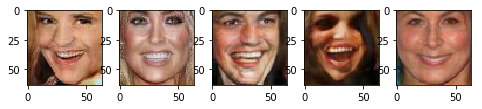

In [15]:
grid_size = 5
plt.figure(figsize=(8, 8))
for i in range(sample_p_opt.shape[0]):
    img = np.clip(sample_p_opt[i], 0, 1) 
    plt.subplot(grid_size, grid_size, i+1)    
    plt.imshow(img)

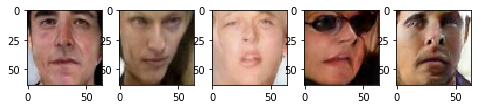

In [16]:
plt.figure(figsize=(8, 8))
for i in range(sample_q_opt.shape[0]):
    img = np.clip(sample_q_opt[i], 0, 1) 
    plt.subplot(grid_size, grid_size, i+1)    
    plt.imshow(img)

In [26]:
print(np.sum((Zp0 - Zp_opt.cpu().data.numpy())**2)**0.5)

2.440954831703507e-06


## Experiments on discrete optimization

### Using real images as samples for the three-sampel UME test, we examine test locations given by maximizing the power criterion. 

In [ ]:
# loading data path
data_dir = '../problems/celeba/img_align_celeba'
test_img_list = []
with open('../problems/celeba/test_list.txt') as f:
    for line in f:
        test_img_list.append(line.rstrip('\n'))
smile_img_list = []
with open('../problems/celeba/test_smile.txt') as f:
    for line in f:
        smile_img_list.append(line.rstrip('\n'))
non_smile_img_list = [filename for filename in test_img_list 
                      if filename not in smile_img_list]

In [ ]:
# loading image data
paths = ['{}/{}'.format(data_dir, filename) for filename in smile_img_list]
smile_img_data = open_images(paths, 224, resize=True)
smile_img_data = smile_img_data / 255
paths = ['{}/{}'.format(data_dir, filename) for filename in non_smile_img_list]
non_smile_img_data = open_images(paths, 224, resize=True)
non_smile_img_data = non_smile_img_data / 255
n1 = smile_img_data.shape[0]
n2 = non_smile_img_data.shape[0]
tr_data = np.vstack([smile_img_data[:int(n1/2)], non_smile_img_data[:int(n2/2)]])
te_data = np.vstack([smile_img_data[int(n1/2):], non_smile_img_data[int(n2/2):]])

In [ ]:
# creating training and test data
mean = np.mean(tr_data, axis=(0, 1, 2))
std = np.std(tr_data, axis=(0, 1, 2))
print(mean, std)

In [ ]:
smile_img_data_norm = normalize(smile_img_data, mean, std)
smile_tr_data = smile_img_data_norm[:int(n1/2)]
smile_te_data = smile_img_data_norm[int(n1/2):]
non_smile_img_data_norm = normalize(non_smile_img_data, mean, std)
non_smile_tr_data = non_smile_img_data_norm[:int(n2/2)]
non_smile_te_data = non_smile_img_data_norm[int(n2/2):]

In [ ]:
del(non_smile_img_data)
del(smile_img_data)

In [ ]:
# loading a feature extractor 
import pretrainedmodels
model_name = 'resnet18'
model = pretrainedmodels.__dict__[model_name]().cuda(2)
model.eval()

In [ ]:
# Obtain samples for P, Q, R
sample_size = 500
half_n1 = int(n1 / 2)
half_n2 = int(n2 / 2)

subsample_idx_p = util.subsample_ind(half_n1, sample_size)
datap = smile_tr_data[subsample_idx_p].reshape(sample_size, -1)
datap = data.Data(datap)

subsample_idx_q = util.subsample_ind(half_n2, sample_size)
dataq = non_smile_tr_data[subsample_idx_q].reshape(sample_size, -1)
dataq = data.Data(dataq)

rest_tr_data = np.vstack(
    [
     np.delete(smile_tr_data, subsample_idx_p, axis=0),
     np.delete(non_smile_tr_data, subsample_idx_q, axis=0)
    ]
)
n = rest_tr_data.shape[0]
datar = util.subsample_rows(rest_tr_data.reshape(n, -1),
                            sample_size)
datar = data.Data(datar)

del(rest_tr_data)

In [ ]:
te_data_norm = normalize(te_data, mean, std)

In [ ]:
num_candidates = 500
locs = util.subsample_rows(te_data_norm, num_candidates)
#locs = smile_img_data_norm[-num_candidates:]
locs = locs.reshape((locs.shape[0], -1))
XYZ = np.vstack((datap.data(), dataq.data(), datar.data()))
med2 = util.meddistance(XYZ, subsample=1000)**2
J = 10

In [ ]:
with util.ContextTimer() as t:
    p_best_locs = gt.opt_greedy_3sample_criterion(datap, dataq, datar,
                                                model.features, locs,
                                                med2, J, maximize=False)

In [ ]:
with util.ContextTimer() as t:
    q_best_locs = gt.opt_greedy_3sample_criterion(datap, dataq, datar,
                                                model.features, locs,
                                                med2, J, maximize=True)

In [ ]:
grid_size = 4
images = locs.reshape((num_candidates, 224, 224, 3)) * std + mean
for i in range(len(p_best_locs)):
    idx = p_best_locs[i]
    img = images[idx]
    plt.subplot(grid_size, grid_size, i+1)
    plt.imshow(img)

In [ ]:
grid_size = 4
for i in range(len(q_best_locs)):
    idx = q_best_locs[i]
    img = images[idx]
    plt.subplot(grid_size, grid_size, i+1)
    plt.imshow(img)